train.csv

- row_id : An ID code for the row.

- cfips : A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

- county_name : The written name of the county.

- state_name : The name of the state.

- first_day_of_month : The date of the first day of the month.

- microbusiness_density : Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.

- active : The raw count of microbusinesses in the county. Not provided for the test set.

sample_submission.csv : A valid sample submission. This file will remain unchanged throughout the competition.

- row_id : An ID code for the row.

- microbusiness_density : The target variable.

test.csv : Metadata for the submission rows. This file will remain unchanged throughout the competition.

- row_id : An ID code for the row.

- cfips : A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

- first_day_of_month : The date of the first day of the month.

census_starter.csv : Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

- pct_bb_[year] : The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.

- cfips : The CFIPS code.

- pct_college_[year] : The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

- pct_foreign_born_[year] : The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

- pct_it_workers_[year] : The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.

- median_hh_inc_[year] : The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

# 시작

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', 100)

# train

In [29]:
train = pd.read_csv('train.csv')
print('len(train):',len(train))
train.head()

len(train): 122265


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [31]:
# train 

print('len(train): ',len(train))
print('row_id key?',len(train.row_id.unique()) == len(train))
print('len(train.cfips.unique()): ',len(train.cfips.unique()))
print('train.cfips.unique(): ',train.cfips.unique())
print('train.cfips.astype(str).str.len().unique(): ',train.cfips.astype(str).str.len().unique()) # 다섯자리로 통일해야 함 
print('len(train.county.unique()): ',len(train.county.unique()))
print('train.county.unique(): ',train.county.unique().tolist()[0:5])
print('len(train.state.unique()): ',len(train.state.unique()))
print('train.state.unique(): ',train.state.unique().tolist()[0:5])

len(train):  122265
row_id key? True
len(train.cfips.unique()):  3135
train.cfips.unique():  [ 1001  1003  1005 ... 56041 56043 56045]
train.cfips.astype(str).str.len().unique():  [4 5]
len(train.county.unique()):  1871
train.county.unique():  ['Autauga County', 'Baldwin County', 'Barbour County', 'Bibb County', 'Blount County']
len(train.state.unique()):  51
train.state.unique():  ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']


- train 컬럼 추가

In [32]:
train['cfips_state'] = train['cfips'].astype(str).str.pad(width=5,side='left',fillchar='0').str[0:2]
train['cfips_county'] = train['cfips'].astype(str).str.pad(width=5,side='left',fillchar='0').str[2:]
train['year'] = train.first_day_of_month.str[0:4].astype(int)
train['month'] = train.first_day_of_month.str[5:7].astype(int)
train[['row_id','cfips','cfips_state','cfips_county','first_day_of_month','year','month']].head()

,row_id,cfips,cfips_state,cfips_county,first_day_of_month,year,month
0,1001_2019-08-01,1001,01,001,2019-08-01,2019,8
1,1001_2019-09-01,1001,01,001,2019-09-01,2019,9
2,1001_2019-10-01,1001,01,001,2019-10-01,2019,10
3,1001_2019-11-01,1001,01,001,2019-11-01,2019,11
4,1001_2019-12-01,1001,01,001,2019-12-01,2019,12


In [33]:
# cfips_county 가 county에 대한 1대1 코드인지..아님
zz = train[['county','cfips_county']].drop_duplicates().reset_index(drop=True)
zz['cnt'] = 1
print('zz.head()')
display(zz.head())
zz.groupby(['county'])['cnt'].sum().reset_index().sort_values(['cnt'],ascending=[False])
del zz

zz.head()


,county,cfips_county,cnt
0,Autauga County,001,1
1,Baldwin County,003,1
2,Barbour County,005,1
3,Bibb County,007,1
4,Blount County,009,1


In [34]:
train[train.year == 2019].month.unique() # 다른 연도는 전체 월 있음

array([ 8,  9, 10, 11, 12])

- active_gr 변수 생성 : test에서는 주어지지 않음.. cfips별 월별 평균 사용?

In [35]:
imsi = train[(train.cfips == 1001)][['cfips','active','year','month']]
imsi.head()

,cfips,active,year,month
0,1001,1249,2019,8
1,1001,1198,2019,9
2,1001,1269,2019,10
3,1001,1243,2019,11
4,1001,1243,2019,12


/var/folders/t_/j9jkj3m17_g5xzx86hy3ql2m0000gn/T/ipykernel_10168/1291709301.py:7: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x29386d790> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns,labs, loc=0)
/var/folders/t_/j9jkj3m17_g5xzx86hy3ql2m0000gn/T/ipykernel_10168/1291709301.py:7: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x2923f0c90> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lns,labs, loc=0)


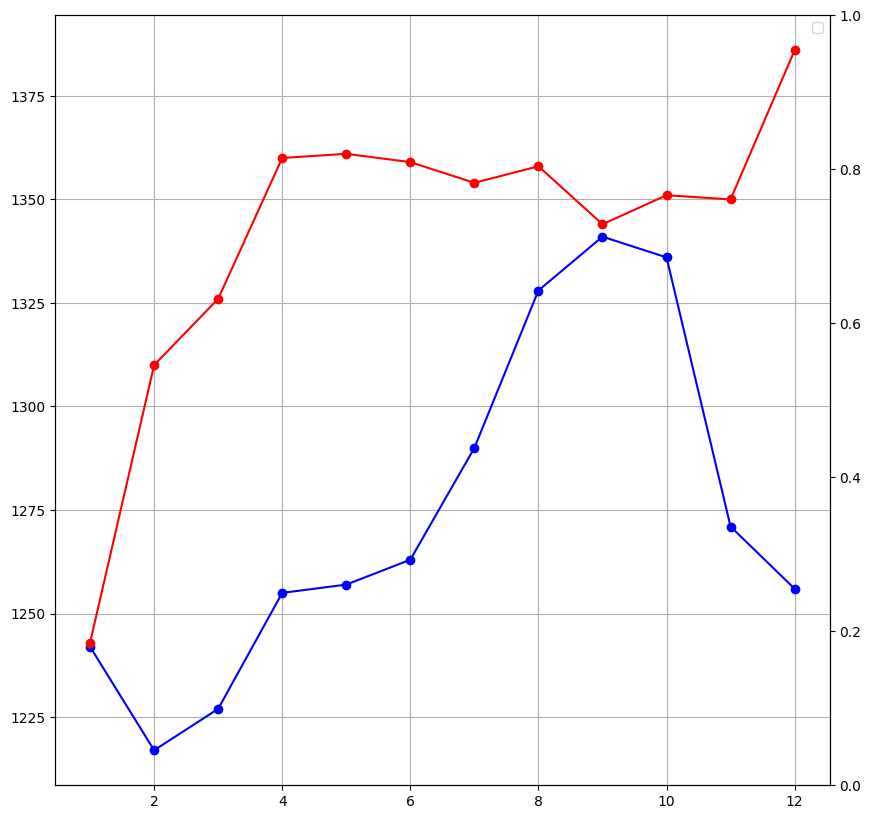

In [36]:
fig, ax1 = plt.subplots(figsize = (10,10))
ax2 = ax1.twinx()
lns1= ax1.plot(imsi[imsi.year == 2020]['month'],imsi[imsi.year == 2020]['active'],color='blue',marker='o')
lns2= ax1.plot(imsi[imsi.year == 2021]['month'],imsi[imsi.year == 2021]['active'],color='red',marker='o')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs, loc=0)
ax1.grid()

In [37]:
# cfips별 월별 acive 평균
active_gr = train.groupby(['cfips','month'])['active'].mean().reset_index()
active_gr.rename(columns={'active':'active_gr'}, inplace=True)
active_gr.head()

,cfips,month,active_gr
0,1001,1,1295.333333
1,1001,2,1314.666667
2,1001,3,1323.666667
3,1001,4,1349.333333
4,1001,5,1342.000000


# test

In [38]:
test = pd.read_csv('test.csv')
print('len(test):',len(test))
test.head()

len(test): 25080


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


- test 컬럼 추가

In [39]:
test['cfips_state'] = test['cfips'].astype(str).str.pad(width=5,side='left',fillchar='0').str[0:2]
test['cfips_county'] = test['cfips'].astype(str).str.pad(width=5,side='left',fillchar='0').str[2:]
test['year'] = test.first_day_of_month.str[0:4].astype(int)
test['month'] = test.first_day_of_month.str[5:7].astype(int)

# cs

In [40]:
cs = pd.read_csv('census_starter.csv')
print('len(cs):',len(cs))
cs.head()

len(cs): 3142


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


- cs 결측치 처리

In [41]:
cs.columns[cs.isna().any()].tolist()

['pct_bb_2020',
 'pct_bb_2021',
 'pct_college_2020',
 'pct_college_2021',
 'pct_foreign_born_2020',
 'pct_foreign_born_2021',
 'pct_it_workers_2018',
 'pct_it_workers_2020',
 'pct_it_workers_2021',
 'median_hh_inc_2018',
 'median_hh_inc_2020',
 'median_hh_inc_2021']

In [42]:
na_cnt = pd.DataFrame(cs.isna().sum()).reset_index()
na_cnt.columns = ['colnm','na_cnt']
na_cnt = na_cnt[na_cnt.na_cnt != 0].sort_values(['na_cnt'], ascending=[False])
na_cnt.head()

,colnm,na_cnt
24,median_hh_inc_2020,2
25,median_hh_inc_2021,2
3,pct_bb_2020,1
4,pct_bb_2021,1
9,pct_college_2020,1


In [43]:
missing_fill_val = {'pct_bb_2020': cs.pct_bb_2020.mean(),
                    'pct_bb_2021': cs.pct_bb_2021.mean(),
                    'pct_college_2020': cs.pct_college_2020.mean(),
                    'pct_college_2021': cs.pct_college_2021.mean(),
                    'pct_foreign_born_2020': cs.pct_foreign_born_2020.mean(),
                    'pct_foreign_born_2021': cs.pct_foreign_born_2021.mean(),
                    'pct_it_workers_2018': cs.pct_it_workers_2018.mean(),
                    'pct_it_workers_2020': cs.pct_it_workers_2020.mean(),
                    'pct_it_workers_2021': cs.pct_it_workers_2021.mean(),
                    'median_hh_inc_2018': cs.median_hh_inc_2018.mean(),
                    'median_hh_inc_2020': cs.median_hh_inc_2020.mean(),
                    'median_hh_inc_2021': cs.median_hh_inc_2021.mean()}
cs = cs.fillna(missing_fill_val)
cs.columns[cs.isna().any()].tolist()

[]

- melt

In [44]:
imsi = cs.copy()
imsi = imsi.melt(id_vars='cfips')
imsi.head()

,cfips,variable,value
0,1001,pct_bb_2017,76.6
1,1003,pct_bb_2017,74.5
2,1005,pct_bb_2017,57.2
3,1007,pct_bb_2017,62.0
4,1009,pct_bb_2017,65.8


In [45]:
n_list = ['pct_bb','pct_college','pct_foreign_born','pct_it_workers','median_hh_inc']

for i in range(0,len(n_list)):
    tmp = imsi[imsi.variable.str.contains(n_list[i])].rename(columns={'value':n_list[i]})
    tmp['year'] = tmp.variable.str[-4:] 
    tmp.drop(['variable'], axis=1, inplace=True)
    globals()['tmp_{}'.format(i)] = tmp.copy()

In [46]:
print(len(tmp_0))
print(len(tmp_1))
cs_rev = pd.merge(tmp_0,tmp_1,on=['cfips','year'], how='outer')
print(len(cs_rev))
cs_rev = pd.merge(cs_rev,tmp_2,on=['cfips','year'], how='outer')
print(len(cs_rev))
cs_rev = pd.merge(cs_rev,tmp_3,on=['cfips','year'], how='outer')
print(len(cs_rev))
cs_rev = pd.merge(cs_rev,tmp_4,on=['cfips','year'], how='outer')
print(len(cs_rev))

cs_rev['year'] = cs_rev['year'].astype(int)
cs_rev.head()

# test는 2022년, 2023년 데이터 -> 변수로 쓸 수 없음..

15710
15710
15710
15710
15710
15710


,cfips,pct_bb,year,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001,76.6,2017,14.5,2.1,1.3,55317.0
1,1003,74.5,2017,20.4,3.2,1.4,52562.0
2,1005,57.2,2017,7.6,2.7,0.5,33368.0
3,1007,62.0,2017,8.1,1.0,1.2,43404.0
4,1009,65.8,2017,8.7,4.5,1.3,47412.0


- cs 컬럼 추가

In [47]:
# pct_bb
cs['pct_bb_avg'] = cs[['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].mean(skipna=True,axis=1)
cs['pct_bb_min'] = cs[['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].min(skipna=True,axis=1)
cs['pct_bb_max'] = cs[['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].max(skipna=True,axis=1)
cs['pct_bb_std'] = cs[['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].std(skipna=True,axis=1)

# pct_college
cs['pct_college_avg'] = cs[['pct_college_2017','pct_college_2018','pct_college_2019','pct_college_2020','pct_college_2021']].mean(skipna=True,axis=1)
cs['pct_college_min'] = cs[['pct_college_2017','pct_college_2018','pct_college_2019','pct_college_2020','pct_college_2021']].min(skipna=True,axis=1)
cs['pct_college_max'] = cs[['pct_college_2017','pct_college_2018','pct_college_2019','pct_college_2020','pct_college_2021']].max(skipna=True,axis=1)
cs['pct_college_std'] = cs[['pct_college_2017','pct_college_2018','pct_college_2019','pct_college_2020','pct_college_2021']].std(skipna=True,axis=1)

# pct_foreign_born
cs['pct_foreign_born_avg'] = cs[['pct_foreign_born_2017','pct_foreign_born_2018','pct_foreign_born_2019','pct_foreign_born_2020','pct_foreign_born_2021']].mean(skipna=True,axis=1)
cs['pct_foreign_born_min'] = cs[['pct_foreign_born_2017','pct_foreign_born_2018','pct_foreign_born_2019','pct_foreign_born_2020','pct_foreign_born_2021']].min(skipna=True,axis=1)
cs['pct_foreign_born_max'] = cs[['pct_foreign_born_2017','pct_foreign_born_2018','pct_foreign_born_2019','pct_foreign_born_2020','pct_foreign_born_2021']].max(skipna=True,axis=1)
cs['pct_foreign_born_std'] = cs[['pct_foreign_born_2017','pct_foreign_born_2018','pct_foreign_born_2019','pct_foreign_born_2020','pct_foreign_born_2021']].std(skipna=True,axis=1)

# pct_it_workers
cs['pct_it_workers_avg'] = cs[['pct_it_workers_2017','pct_it_workers_2018','pct_it_workers_2019','pct_it_workers_2020','pct_it_workers_2021']].mean(skipna=True,axis=1)
cs['pct_it_workers_min'] = cs[['pct_it_workers_2017','pct_it_workers_2018','pct_it_workers_2019','pct_it_workers_2020','pct_it_workers_2021']].min(skipna=True,axis=1)
cs['pct_it_workers_max'] = cs[['pct_it_workers_2017','pct_it_workers_2018','pct_it_workers_2019','pct_it_workers_2020','pct_it_workers_2021']].max(skipna=True,axis=1)
cs['pct_it_workers_std'] = cs[['pct_it_workers_2017','pct_it_workers_2018','pct_it_workers_2019','pct_it_workers_2020','pct_it_workers_2021']].std(skipna=True,axis=1)

# median_hh_inc
cs['median_hh_inc_avg'] = cs[['median_hh_inc_2017','median_hh_inc_2018','median_hh_inc_2019','median_hh_inc_2020','median_hh_inc_2021']].mean(skipna=True,axis=1)
cs['median_hh_inc_min'] = cs[['median_hh_inc_2017','median_hh_inc_2018','median_hh_inc_2019','median_hh_inc_2020','median_hh_inc_2021']].min(skipna=True,axis=1)
cs['median_hh_inc_max'] = cs[['median_hh_inc_2017','median_hh_inc_2018','median_hh_inc_2019','median_hh_inc_2020','median_hh_inc_2021']].max(skipna=True,axis=1)
cs['median_hh_inc_std'] = cs[['median_hh_inc_2017','median_hh_inc_2018','median_hh_inc_2019','median_hh_inc_2020','median_hh_inc_2021']].std(skipna=True,axis=1)

cs[['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021','pct_bb_max']].head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_bb_max
0,76.6,78.9,80.6,82.7,85.5,85.5
1,74.5,78.1,81.8,85.1,87.9,87.9
2,57.2,60.4,60.5,64.6,64.6,64.6
3,62.0,66.1,69.2,76.1,74.6,76.1
4,65.8,68.5,73.0,79.6,81.0,81.0


In [48]:
cs[['cfips','pct_bb_std','pct_college_std','median_hh_inc_std']].head()

,cfips,pct_bb_std,pct_college_std,median_hh_inc_std
0,1001,3.426806,0.849706,2629.165970
1,1003,5.351822,0.303315,4649.493435
2,1005,3.158797,0.430116,1500.934109
3,1007,5.861314,0.620484,4489.204239
4,1009,6.670232,0.438178,2026.998964


In [123]:
cs.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_avg,pct_bb_min,pct_bb_max,pct_bb_std,pct_college_avg,pct_college_min,pct_college_max,pct_college_std,pct_foreign_born_avg,pct_foreign_born_min,pct_foreign_born_max,pct_foreign_born_std,pct_it_workers_avg,pct_it_workers_min,pct_it_workers_max,pct_it_workers_std,median_hh_inc_avg,median_hh_inc_min,median_hh_inc_max,median_hh_inc_std
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.165970
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0,81.48,74.5,87.9,5.351822,20.58,20.2,21.0,0.303315,3.44,3.2,3.7,0.181659,1.28,1.0,1.4,0.164317,58589.2,52562.0,64346.0,4649.493435
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0,61.46,57.2,64.6,3.158797,7.40,6.7,7.8,0.430116,2.62,2.5,2.7,0.083666,0.70,0.3,1.1,0.308221,34298.2,32525.0,36422.0,1500.934109
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0,69.60,62.0,76.1,5.861314,7.50,6.5,8.1,0.620484,1.32,1.0,1.6,0.258844,1.60,1.2,2.1,0.339116,48456.8,43404.0,54277.0,4489.204239
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0,73.58,65.8,81.0,6.670232,8.72,8.1,9.3,0.438178,4.46,4.4,4.5,0.054772,1.12,0.9,1.4,0.228035,49443.4,47412.0,52830.0,2026.998964


In [124]:
print(len(cs.cfips.unique()))
print(len(cs))

3142
3142


# train + cs

In [125]:
print(len(train))
train = pd.merge(train,cs,on='cfips',how='left')
print(len(train))
train.head()

122265
122265


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,cfips_state,cfips_county,year,month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_avg,pct_bb_min,pct_bb_max,pct_bb_std,pct_college_avg,pct_college_min,pct_college_max,pct_college_std,pct_foreign_born_avg,pct_foreign_born_min,pct_foreign_born_max,pct_foreign_born_std,pct_it_workers_avg,pct_it_workers_min,pct_it_workers_max,pct_it_workers_std,median_hh_inc_avg,median_hh_inc_min,median_hh_inc_max,median_hh_inc_std
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,01,001,2019,8,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,01,001,2019,9,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,01,001,2019,10,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,01,001,2019,11,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,01,001,2019,12,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597


# test + cs

In [126]:
print(len(test))
test = pd.merge(test,cs,on='cfips',how='left')
print(len(test))
test.head()

25080
25080


,row_id,cfips,first_day_of_month,cfips_state,cfips_county,year,month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_avg,pct_bb_min,pct_bb_max,pct_bb_std,pct_college_avg,pct_college_min,pct_college_max,pct_college_std,pct_foreign_born_avg,pct_foreign_born_min,pct_foreign_born_max,pct_foreign_born_std,pct_it_workers_avg,pct_it_workers_min,pct_it_workers_max,pct_it_workers_std,median_hh_inc_avg,median_hh_inc_min,median_hh_inc_max,median_hh_inc_std
0,1001_2022-11-01,1001,2022-11-01,01,001,2022,11,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.165970
1,1003_2022-11-01,1003,2022-11-01,01,003,2022,11,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0,81.48,74.5,87.9,5.351822,20.58,20.2,21.0,0.303315,3.44,3.2,3.7,0.181659,1.28,1.0,1.4,0.164317,58589.2,52562.0,64346.0,4649.493435
2,1005_2022-11-01,1005,2022-11-01,01,005,2022,11,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0,61.46,57.2,64.6,3.158797,7.40,6.7,7.8,0.430116,2.62,2.5,2.7,0.083666,0.70,0.3,1.1,0.308221,34298.2,32525.0,36422.0,1500.934109
3,1007_2022-11-01,1007,2022-11-01,01,007,2022,11,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0,69.60,62.0,76.1,5.861314,7.50,6.5,8.1,0.620484,1.32,1.0,1.6,0.258844,1.60,1.2,2.1,0.339116,48456.8,43404.0,54277.0,4489.204239
4,1009_2022-11-01,1009,2022-11-01,01,009,2022,11,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0,73.58,65.8,81.0,6.670232,8.72,8.1,9.3,0.438178,4.46,4.4,4.5,0.054772,1.12,0.9,1.4,0.228035,49443.4,47412.0,52830.0,2026.998964


# train + active_gr

In [127]:
print(len(train))
train = pd.merge(train,active_gr,on=['cfips','month'],how='left')
print(len(train))
train.head()

122265
122265


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,cfips_state,cfips_county,year,month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_avg,pct_bb_min,pct_bb_max,pct_bb_std,pct_college_avg,pct_college_min,pct_college_max,pct_college_std,pct_foreign_born_avg,pct_foreign_born_min,pct_foreign_born_max,pct_foreign_born_std,pct_it_workers_avg,pct_it_workers_min,pct_it_workers_max,pct_it_workers_std,median_hh_inc_avg,median_hh_inc_min,median_hh_inc_max,median_hh_inc_std,active_gr
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,01,001,2019,8,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597,1347.5
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,01,001,2019,9,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597,1336.5
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,01,001,2019,10,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597,1357.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,01,001,2019,11,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597,1288.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,01,001,2019,12,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.16597,1295.0


# test + active_gr

In [128]:
print(len(test))
test = pd.merge(test,active_gr,on=['cfips','month'],how='left')
print(len(test))
test.head()

25080
25080


,row_id,cfips,first_day_of_month,cfips_state,cfips_county,year,month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_avg,pct_bb_min,pct_bb_max,pct_bb_std,pct_college_avg,pct_college_min,pct_college_max,pct_college_std,pct_foreign_born_avg,pct_foreign_born_min,pct_foreign_born_max,pct_foreign_born_std,pct_it_workers_avg,pct_it_workers_min,pct_it_workers_max,pct_it_workers_std,median_hh_inc_avg,median_hh_inc_min,median_hh_inc_max,median_hh_inc_std,active_gr
0,1001_2022-11-01,1001,2022-11-01,01,001,2022,11,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0,80.86,76.6,85.5,3.426806,15.92,14.5,16.7,0.849706,2.16,2.0,2.3,0.134164,0.96,0.6,1.3,0.296648,58695.2,55317.0,62660.0,2629.165970,1288.000000
1,1003_2022-11-01,1003,2022-11-01,01,003,2022,11,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0,81.48,74.5,87.9,5.351822,20.58,20.2,21.0,0.303315,3.44,3.2,3.7,0.181659,1.28,1.0,1.4,0.164317,58589.2,52562.0,64346.0,4649.493435,12781.333333
2,1005_2022-11-01,1005,2022-11-01,01,005,2022,11,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0,61.46,57.2,64.6,3.158797,7.40,6.7,7.8,0.430116,2.62,2.5,2.7,0.083666,0.70,0.3,1.1,0.308221,34298.2,32525.0,36422.0,1500.934109,216.000000
3,1007_2022-11-01,1007,2022-11-01,01,007,2022,11,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0,69.60,62.0,76.1,5.861314,7.50,6.5,8.1,0.620484,1.32,1.0,1.6,0.258844,1.60,1.2,2.1,0.339116,48456.8,43404.0,54277.0,4489.204239,226.666667
4,1009_2022-11-01,1009,2022-11-01,01,009,2022,11,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0,73.58,65.8,81.0,6.670232,8.72,8.1,9.3,0.438178,4.46,4.4,4.5,0.054772,1.12,0.9,1.4,0.228035,49443.4,47412.0,52830.0,2026.998964,729.000000


# 상관계수

In [129]:
train.corr()

C:\Users\USER\AppData\Local\Temp\ipykernel_12220\2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,cfips,microbusiness_density,active,year,month,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,pct_bb_avg,pct_bb_min,pct_bb_max,pct_bb_std,pct_college_avg,pct_college_min,pct_college_max,pct_college_std,pct_foreign_born_avg,pct_foreign_born_min,pct_foreign_born_max,pct_foreign_born_std,pct_it_workers_avg,pct_it_workers_min,pct_it_workers_max,pct_it_workers_std,median_hh_inc_avg,median_hh_inc_min,median_hh_inc_max,median_hh_inc_std,active_gr
cfips,1.000000e+00,-0.011767,-0.062760,-2.679051e-12,-1.541200e-14,3.026460e-02,3.633271e-02,4.044383e-02,3.873089e-02,4.098382e-02,4.749287e-02,4.190217e-02,4.374162e-02,4.639474e-02,4.952584e-02,-1.757810e-02,-1.897061e-02,-1.537046e-02,-2.029040e-02,-1.831529e-02,-5.005333e-02,-4.600879e-02,-4.005157e-02,-2.255512e-02,-2.190076e-02,7.240960e-02,6.845947e-02,6.428708e-02,6.126155e-02,5.860686e-02,3.802077e-02,3.386259e-02,3.823371e-02,-9.890687e-03,4.645542e-02,4.233218e-02,5.000958e-02,3.216729e-02,-1.820024e-02,-2.308965e-02,-1.444008e-02,3.375992e-02,-4.000337e-02,-3.157918e-02,-4.268649e-02,-2.146004e-02,6.544911e-02,6.512884e-02,6.406030e-02,3.050091e-02,-0.062835
microbusiness_density,-1.176709e-02,1.000000,0.316981,1.702471e-02,2.121343e-03,3.934851e-01,3.835920e-01,3.712211e-01,3.553518e-01,3.495662e-01,4.804088e-01,4.817638e-01,4.825572e-01,4.766351e-01,4.841530e-01,2.729279e-01,2.763180e-01,2.758997e-01,2.844841e-01,2.809560e-01,2.520168e-01,2.591785e-01,2.464040e-01,2.496068e-01,2.419215e-01,3.650385e-01,3.738621e-01,3.830058e-01,3.912930e-01,3.943205e-01,3.810509e-01,3.920069e-01,3.547626e-01,-2.429711e-01,4.876362e-01,4.893344e-01,4.758709e-01,-6.239223e-03,2.796423e-01,2.877010e-01,2.677777e-01,7.274884e-03,2.773926e-01,3.276009e-01,2.071174e-01,-4.677571e-02,3.863722e-01,3.725687e-01,3.923814e-01,2.429835e-01,0.306063
active,-6.275991e-02,0.316981,1.000000,4.035053e-03,4.860858e-04,2.216997e-01,2.170717e-01,2.119334e-01,2.072305e-01,2.053728e-01,2.763590e-01,2.787186e-01,2.801796e-01,2.769546e-01,2.787800e-01,4.292746e-01,4.312816e-01,4.303828e-01,4.334071e-01,4.327333e-01,2.542626e-01,2.652193e-01,2.574384e-01,2.397413e-01,2.440070e-01,2.316319e-01,2.392858e-01,2.488337e-01,2.555125e-01,2.563141e-01,2.183693e-01,2.227178e-01,2.056823e-01,-1.330792e-01,2.819792e-01,2.933770e-01,2.637566e-01,-8.064971e-02,4.337865e-01,4.519207e-01,4.107244e-01,-3.955613e-02,2.798109e-01,3.567032e-01,1.834917e-01,-1.093917e-01,2.495856e-01,2.383825e-01,2.536669e-01,1.599572e-01,0.998806
year,-2.679051e-12,0.017025,0.004035,1.000000e+00,-3.257756e-01,-2.926547e-13,-2.753878e-13,-3.137529e-13,-2.896762e-13,-3.194211e-13,-1.546246e-13,-1.392095e-13,-1.558249e-13,-1.532277e-13,-1.305100e-13,1.196875e-12,1.179061e-12,1.151227e-12,1.156400e-12,1.145429e-12,4.191786e-14,-8.128002e-14,-4.874394e-14,-6.937164e-14,-7.491694e-14,-7.106153e-14,-2.094742e-14,-7.124679e-15,8.065806e-14,6.731564e-14,-3.048497e-13,-3.304233e-13,-2.680901e-13,2.534307e-13,-1.486002e-13,-1.700624e-13,-1.259344e-13,1.579937e-13,1.172177e-12,1.117736e-12,1.220723e-12,8.822825e-13,-5.113723e-14,-8.549487e-14,6.108690e-15,8.167954e-14,1.286648e-14,-7.190758e-14,8.237241e-14,5.173362e-13,-0.000020
month,-1.541200e-14,0.002121,0.000486,-3.257756e-01,1.000000e+00,7.417366e-17,-2.105340e-17,-7.146666e-17,-7.258759e-17,-5.852061e-17,-3.851434e-16,-2.967843e-16,-3.083871e-16,-3.457436e-16,-4.238337e-16,-1.784719e-16,-1.493663e-16,-1.856107e-16,-1.251291e-16,-1.457356e-16,9.342377e-16,9.200176e-16,8.634674e-16,5.343387e-16,5.258819e-16,-7.408925e-16,-7.198899e-16,-6.539422e-16,-6.255908e-16,-5.871295e-16,-2.392147e-17,3.475886e-17,-3.968346e-1

# 모델

In [130]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122265 entries, 0 to 122264
Data columns (total 57 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
 7   cfips_state            122265 non-null  object 
 8   cfips_county           122265 non-null  object 
 9   year                   122265 non-null  int32  
 10  month                  122265 non-null  int32  
 11  pct_bb_2017            122265 non-null  float64
 12  pct_bb_2018            122265 non-null  float64
 13  pct_bb_2019            122265 non-null  float64
 14  pct_bb_2020            122265 non-nu

- test1 : R2(0.9865799096411708) , rmse(0.558579369778285) = 49.9218
- test2 : R2(0.9872220551193496), rmse(0.5450516728635211) = 79.4645
- test3 : R2(0.9862142490811798), rmse(0.5661381030650269) = 38.3533(best)
- test4 : R2(0.9849080528450255), rmse(0.5923519324668197) = 62.5212
- test5 : R2(0.9900957865646932), rmse(0.47986289205472255) = 34.3537

R2: 0.9900957865646932
rmse: 0.47986289205472255
mape: inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   row_id                 25080 non-null  object 
 1   microbusiness_density  25080 non-null  float32
dtypes: float32(1), object(1)
memory usage: 294.0+ KB
None


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

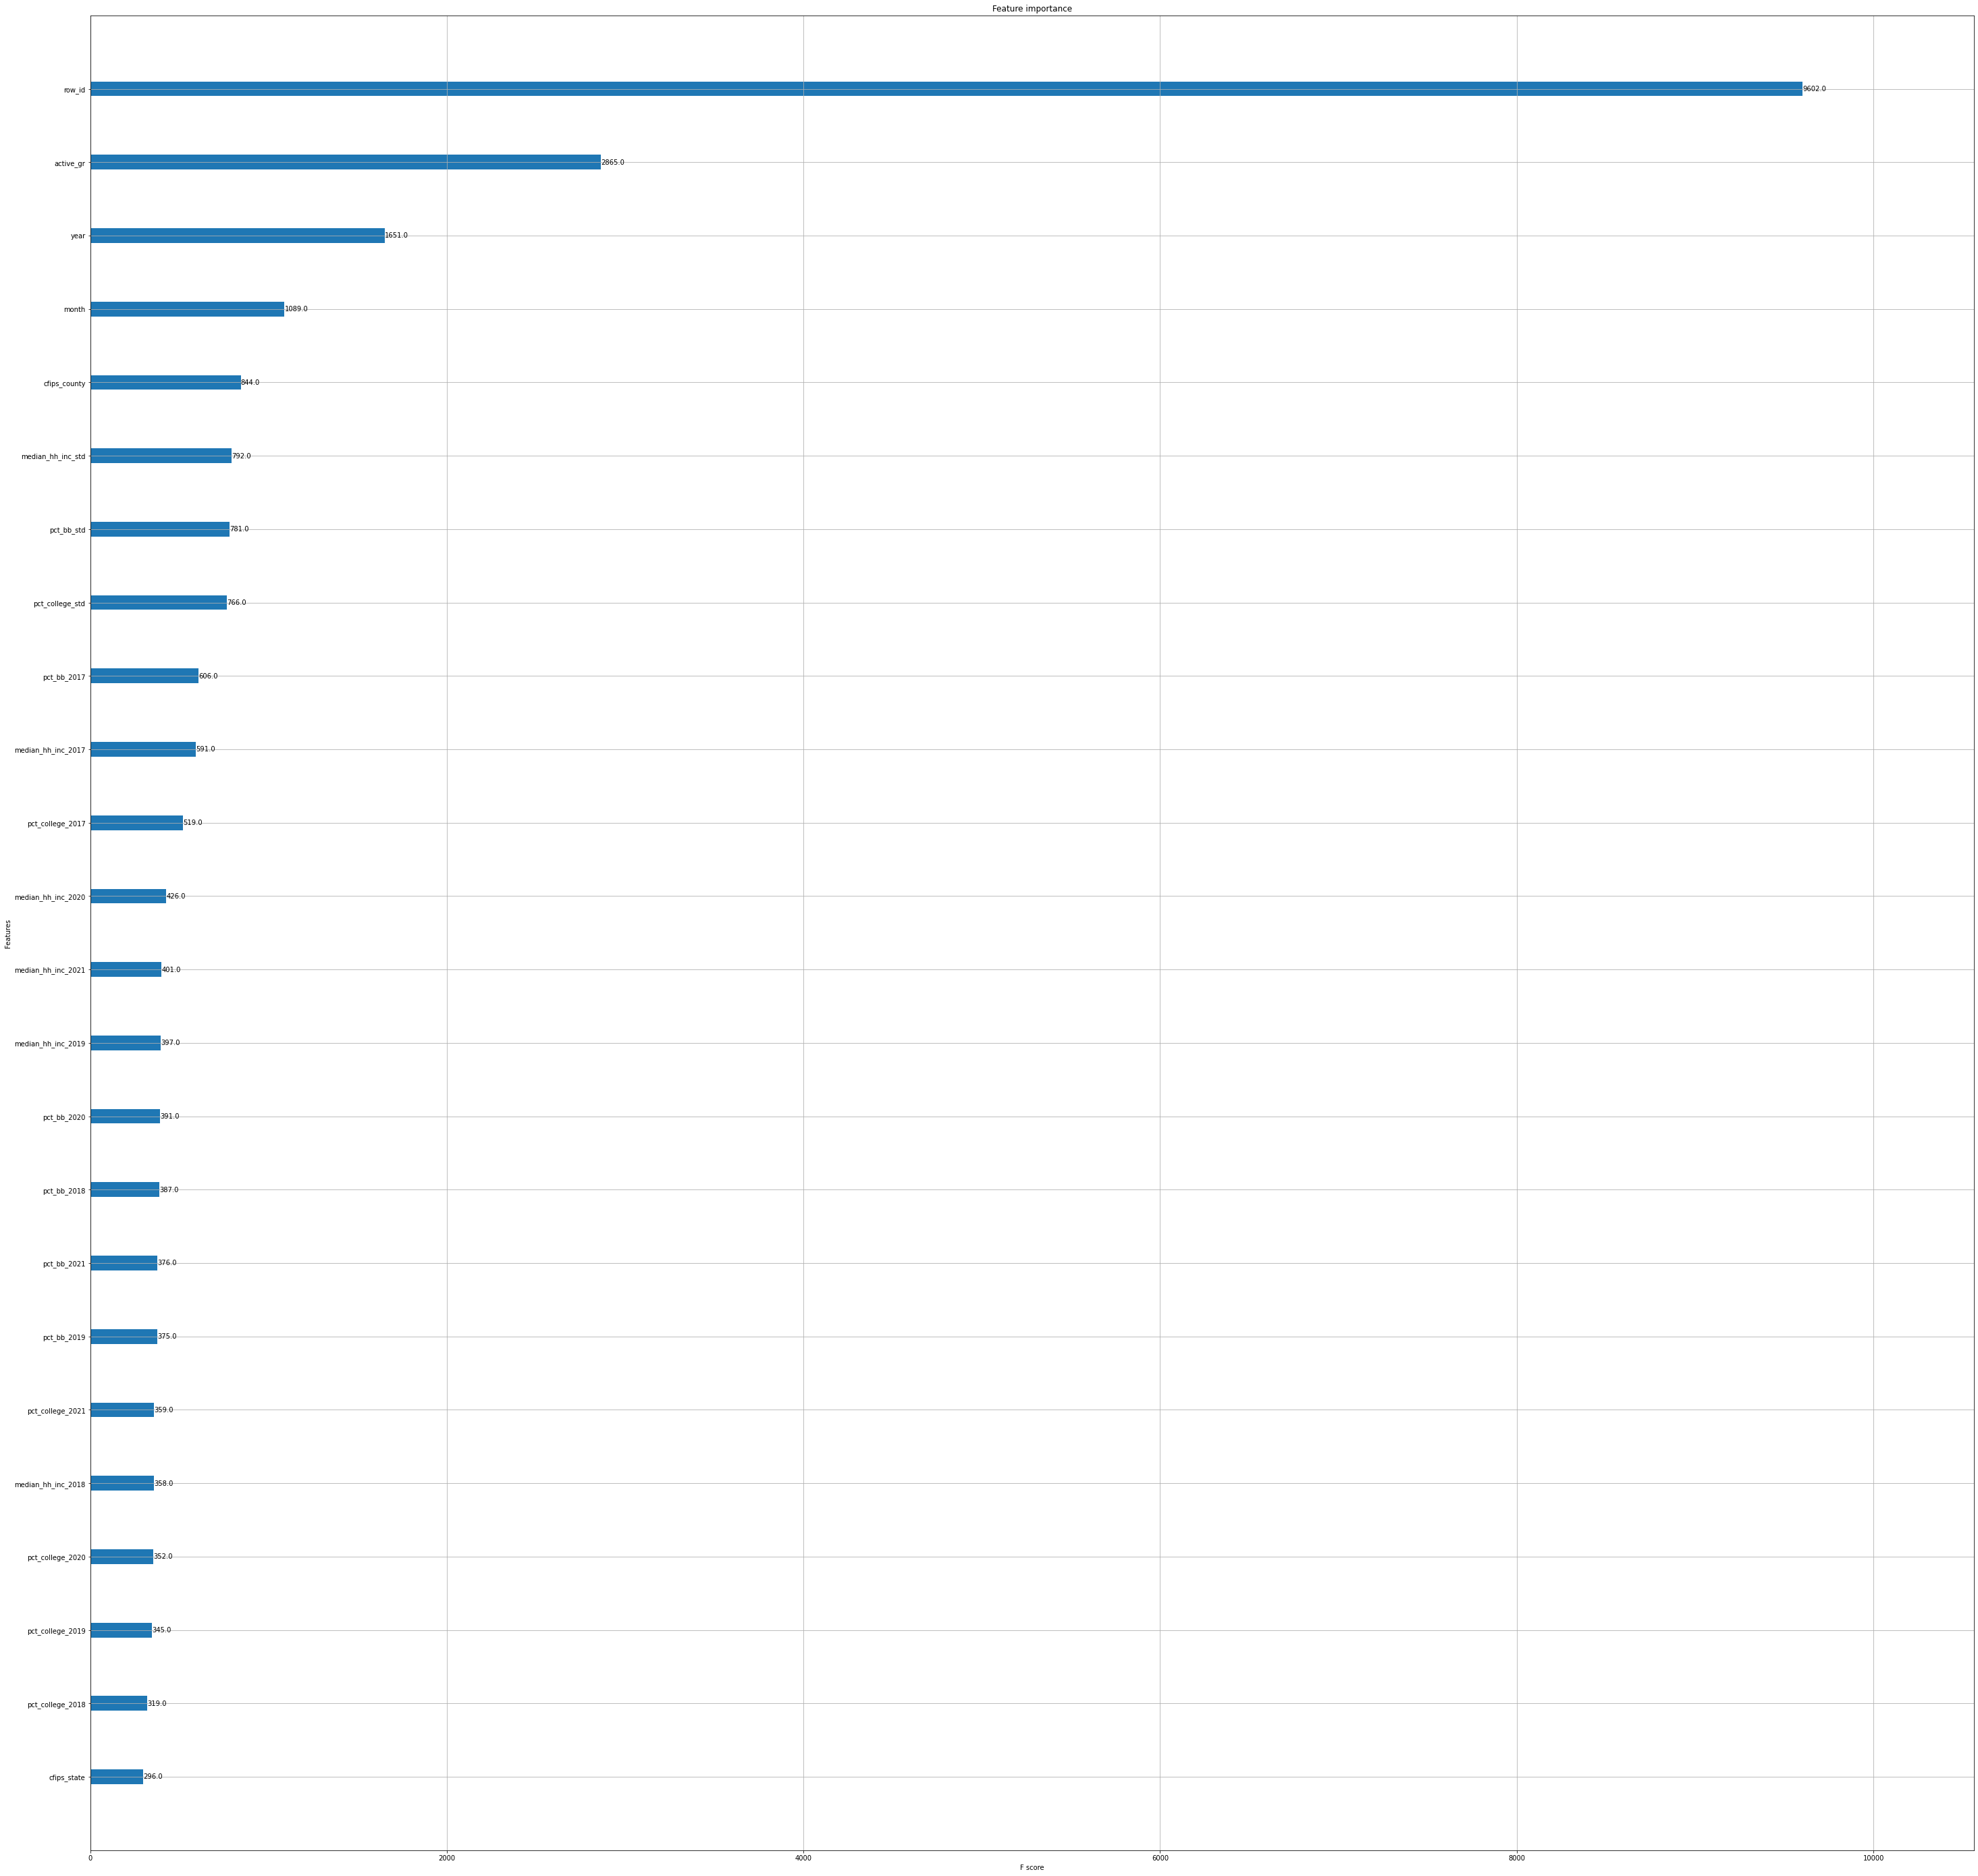

In [131]:
# 변수 선택
col_nm = ['row_id', 'cfips_state', 'cfips_county','year','month','active_gr',
          'pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020','pct_bb_2021',
          'pct_college_2017', 'pct_college_2018','pct_college_2019', 'pct_college_2020', 'pct_college_2021',
          'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019','median_hh_inc_2020', 'median_hh_inc_2021',
          'pct_bb_std','pct_college_std','median_hh_inc_std']

# label encoding
str_col = ['row_id','cfips_state','cfips_county']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
#     for label in np.unique(test[i]):
    for label in (test[i].unique()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

x_train, x_valid, y_train, y_valid = train_test_split(train[col_nm], train['microbusiness_density'], test_size=0.2, shuffle=True, random_state=34)
# print(x_train.shape,y_train.shape)

model = XGBRegressor(n_estimators=500)
model.fit(x_train,y_train) 

from sklearn.metrics import accuracy_score

y_pred = model.predict(x_valid)

# 예측 라벨과 실제 라벨 사이의 정확도 측정
print('R2:', model.score(x_valid, y_valid)) 
print('rmse:',mean_squared_error(y_valid, y_pred, squared=False))
print('mape:', np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100)

preds = model.predict(test[col_nm])

sample = pd.read_csv('sample_submission.csv')
sample.drop(['microbusiness_density'],axis=1, inplace=True)

sample['microbusiness_density'] = preds
sample.to_csv('submission.csv',index=False)
print(sample.info())

plt.rcParams["figure.figsize"] = (50,50)
plot_importance(model)
